In [211]:
# load packages
import os
import geopandas as gpd
import leafmap.foliumap as leafmap
import requests
import rioxarray as rxr
import xarray
import matplotlib.pyplot as plt
import numpy as np
from folium import Map
from folium.raster_layers import ImageOverlay
import leafmap.colormaps as cm
from geocube.api.core import make_geocube
import math
import pandas as pd

In [212]:
# define print raster function to help compare reprojections
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
        f"NoDataValue: {raster.rio.nodata}\n"
        f"NoDataOriginalValues: {raster.rio.encoded_nodata}\n"
    )

In [213]:
# load data layer filepaths
data_folder = './carbon_stock_data/output_layers/'
rra_filepath = './study_area/Study_Area_RRA_MOU_revised/RRA_nonoverlap_3_revised.shp'
biomass_filepath = data_folder + 'carbon_sothe_spawn_t_laea.tif'
biomass_err_filepath = data_folder + 'carbon_err_sothe_spawn_t_laea.tif'
soc_filepath = data_folder + 'soc_0_1m_t_laea.tif'
soc_err_filepath = data_folder + 'soc_err_0_1m_t_laea.tif'

In [214]:
# load first raster and extract CRS
crs = rxr.open_rasterio(biomass_filepath).rio.crs

# load study area shp
rra = gpd.read_file(rra_filepath).to_crs(crs)
rra

,FN_TRADITI,FN_TRADI_1,FN_TERRITO,ENV_NAME_C,CIG_NAME_C,RATIFIED_I,RATIFIED_D,GEOMETRY_L,GEOMETRY_A,geometry
0,15,Kaska Dena Nation (Ross River and Liard),Traditional Territory,None,KASKA,None,0000/00/00,1.261018e+06,4.107575e+10,"MULTIPOLYGON (((-176918.298 770244.601, -17646..."


In [215]:
# load biomass carbon in tonnes
biomass = rxr.open_rasterio(
    biomass_filepath, masked=True
).rio.clip(
    rra.geometry.values, rra.crs, from_disk=True)

# load biomass carbon std err in tonnes
biomass_err = rxr.open_rasterio(
    biomass_err_filepath, masked=True
).rio.clip(
    rra.geometry.values, rra.crs, from_disk=True)

# load soc in tonnes
soc = rxr.open_rasterio(
    soc_filepath, masked=True
).rio.clip(
    rra.geometry.values, rra.crs, from_disk=True)

# load soc std err in tonnes
soc_err = rxr.open_rasterio(
    soc_err_filepath, masked=True
).rio.clip(
    rra.geometry.values, rra.crs, from_disk=True)


In [216]:
# create output grid
out_grid = make_geocube(
    vector_data=rra,
    like=biomass)
out_grid

<xarray.Dataset> Size: 33MB
Dimensions:      (y: 1086, x: 1275)
Coordinates:
  * y            (y) float64 9kB 9.269e+05 9.266e+05 ... 6.559e+05 6.556e+05
  * x            (x) float64 10kB -4.867e+05 -4.865e+05 ... -1.682e+05
    spatial_ref  int64 8B 0
Data variables:
    FN_TRADITI   (y, x) float64 11MB nan nan nan nan nan ... nan nan nan nan nan
    GEOMETRY_L   (y, x) float64 11MB nan nan nan nan nan ... nan nan nan nan nan
    GEOMETRY_A   (y, x) float64 11MB nan nan nan nan nan ... nan nan nan nan nan

In [217]:
# merge the datacube with the carbon variables together
out_grid['biomass'] = (biomass.dims, biomass.values, biomass.attrs, biomass.encoding)
out_grid['biomass_err'] = (biomass_err.dims, biomass_err.values, biomass_err.attrs, biomass_err.encoding)
out_grid['soc'] = (soc.dims, soc.values, soc.attrs, soc.encoding)
out_grid['soc_err'] = (soc_err.dims, soc_err.values, soc_err.attrs, soc_err.encoding)
out_grid

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1086, x: 1275, band: 1)
Coordinates:
  * y            (y) float64 9kB 9.269e+05 9.266e+05 ... 6.559e+05 6.556e+05
  * x            (x) float64 10kB -4.867e+05 -4.865e+05 ... -1.682e+05
    spatial_ref  int64 8B 0
Dimensions without coordinates: band
Data variables:
    FN_TRADITI   (y, x) float64 11MB nan nan nan nan nan ... nan nan nan nan nan
    GEOMETRY_L   (y, x) float64 11MB nan nan nan nan nan ... nan nan nan nan nan
    GEOMETRY_A   (y, x) float64 11MB nan nan nan nan nan ... nan nan nan nan nan
    biomass      (band, y, x) float64 11MB nan nan nan nan ... nan nan nan nan
    biomass_err  (band, y, x) float64 11MB nan nan nan nan ... nan nan nan nan
    soc          (band, y, x) float64 11MB nan nan nan nan ... nan nan nan nan
    soc_err      (band, y, x) float64 11MB nan nan nan nan ... nan nan nan nan

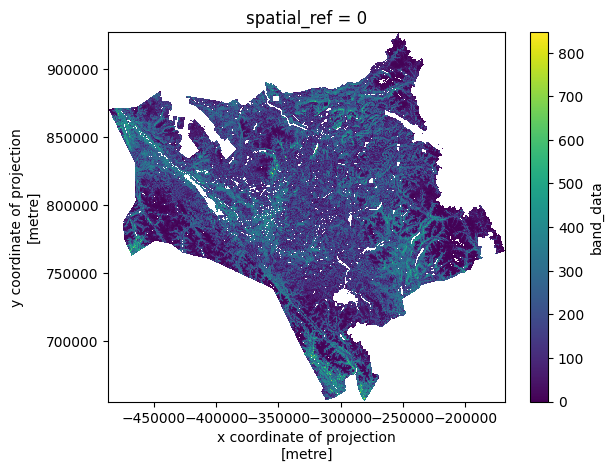

In [218]:
# plot the carbon
out_grid.biomass.plot()

In [219]:
# add carbon stock data to shapefile
rra['BIO_C_T'] = out_grid['biomass'].sum().values.round(1)
rra['BIO_C_SE_T'] = math.sqrt((out_grid['biomass_err'] ** 2).sum().values)
rra['SOC_T'] = out_grid['soc'].sum().values.round(1)
rra['SOC_SE_T'] = math.sqrt((out_grid['soc_err'] ** 2).sum().values)
rra

,FN_TRADITI,FN_TRADI_1,FN_TERRITO,ENV_NAME_C,CIG_NAME_C,RATIFIED_I,RATIFIED_D,GEOMETRY_L,GEOMETRY_A,geometry,BIO_C_T,BIO_C_SE_T,SOC_T,SOC_SE_T
0,15,Kaska Dena Nation (Ross River and Liard),Traditional Territory,None,KASKA,None,0000/00/00,1.261018e+06,4.107575e+10,"MULTIPOLYGON (((-176918.298 770244.601, -17646...",100583624.2,57465.658987,730444770.3,509959.722042


In [220]:
math.sqrt((out_grid['biomass_err'] ** 2).sum().values)


57465.65898717928

In [221]:
math.sqrt((biomass_err ** 2).sum().values)

57465.65898717928

In [186]:
# round columns
decimals = pd.Series([1,1,1,1], index=['BIO_C_T', 'BIO_C_SE_T', 'SOC_T', 'SOC_SE_T'])
rra = rra.round(decimals)
rra

,FN_TRADITI,FN_TRADI_1,FN_TERRITO,ENV_NAME_C,CIG_NAME_C,RATIFIED_I,RATIFIED_D,GEOMETRY_L,GEOMETRY_A,geometry,BIO_C_T,BIO_C_SE_T,SOC_T,SOC_SE_T
0,15,Kaska Dena Nation (Ross River and Liard),Traditional Territory,None,KASKA,None,0000/00/00,1.261018e+06,4.107575e+10,"MULTIPOLYGON (((-176918.298 770244.601, -17646...",100583624.2,57465.7,730444770.3,509959.7


In [187]:
cols = ['BIO_C_T', 'BIO_C_SE_T', 'SOC_T', 'SOC_SE_T']
for c in cols:
    rra[c] = rra[c].apply(lambda x: f"{x:.1f}")
rra

,FN_TRADITI,FN_TRADI_1,FN_TERRITO,ENV_NAME_C,CIG_NAME_C,RATIFIED_I,RATIFIED_D,GEOMETRY_L,GEOMETRY_A,geometry,BIO_C_T,BIO_C_SE_T,SOC_T,SOC_SE_T
0,15,Kaska Dena Nation (Ross River and Liard),Traditional Territory,None,KASKA,None,0000/00/00,1.261018e+06,4.107575e+10,"MULTIPOLYGON (((-176918.298 770244.601, -17646...",100583624.2,57465.7,730444770.3,509959.7


In [188]:
# write to file
rra.to_file('./study_area/RRA_nonoverlap_3_revised_carbon_stocks.shp')

# LEAFMAP BELOW

In [79]:
cm.palettes.viridis

Box({'default': ('440154', '440256', '450457', '450559', '46075a', '46085c', '460a5d', '460b5e', '470d60', '470e61', '471063', '471164', '471365', '481467', '481668', '481769', '48186a', '481a6c', '481b6d', '481c6e', '481d6f', '481f70', '482071', '482173', '482374', '482475', '482576', '482677', '482878', '482979', '472a7a', '472c7a', '472d7b', '472e7c', '472f7d', '46307e', '46327e', '46337f', '463480', '453581', '453781', '453882', '443983', '443a83', '443b84', '433d84', '433e85', '423f85', '424086', '424186', '414287', '414487', '404588', '404688', '3f4788', '3f4889', '3e4989', '3e4a89', '3e4c8a', '3d4d8a', '3d4e8a', '3c4f8a', '3c508b', '3b518b', '3b528b', '3a538b', '3a548c', '39558c', '39568c', '38588c', '38598c', '375a8c', '375b8d', '365c8d', '365d8d', '355e8d', '355f8d', '34608d', '34618d', '33628d', '33638d', '32648e', '32658e', '31668e', '31678e', '31688e', '30698e', '306a8e', '2f6b8e', '2f6c8e', '2e6d8e', '2e6e8e', '2e6f8e', '2d708e', '2d718e', '2c718e', '2c728e', '2c738e', '2b

In [83]:
# set parameters
m = leafmap.Map(width=800, height=500, google_map='HYBRID', zoom=10)
m.add_raster(biomass, colormap='viridis', layer_name='Biomass Carbon (t)', nodata=np.nan)
m

In [7]:
# add data layers
m = leafmap.Map(width=800, height=500)



m.add_shp(rra_filepath, layer_name='Study Area')
m

'./study_area/RRA_nonoverlap_3_revised_carbon_stocks.shp'